In [2]:
import soundfile as sf
from IPython.display import Audio
import numpy as np
import random 
import pandas as pd
import os
from os.path import join as pjoin
import tqdm
from acoustics.bands import third
import scipy.signal as sig
from IPython.display import Audio
# from masp import shoebox_room_sim as srs
from scipy.io import wavfile
#import mat73
import matplotlib.pyplot as plt

In [37]:
# import my modules:
import sys
sys.path.append('../src')
import joa_helpers as hlp
import importlib
importlib.reload(hlp);

In [38]:
np.random.seed(42)

# datapath="/media/ssd2/RESULTS-reverb-match-cond-u-net/"
datapath="/home/ubuntu/Data/"

In [39]:
# # ---------- NOISE POOL ------------
# # create df with paths to noise files 
# noise_path=pjoin(datapath,'wham')
# database="wham"
# noise_pool = []
# for split in ['tr', 'cv', 'tt']:
#     split_path = pjoin(pjoin(noise_path, 'wham_noise'), split)
#     for audio_path in os.listdir(split_path):
#         noise_pool.append({'database_noise': database, 'noise_file_path': pjoin(split_path,audio_path)})

# noise_pool=pd.DataFrame(noise_pool)
# print(f"{len(noise_pool)=}")

# noise_pool.to_csv("noise_pool.csv")
# noise_pool.head(10)

In [40]:
# ---------- SPEECH POOL ------------

# create df with paths to speech files
speech_dataset_path1 =  pjoin(datapath,'VCTK','wav48_silence_trimmed')
speech_dataset_path2 =  pjoin(datapath,'LibriMix','LibriSpeech')
speech_dataset_path3 =  pjoin(datapath,'PTDB')

# initialize empty list of files:
speech_pool = []

# fill the list of files with filenames from vctk data base:
database="VCTK"
for root, dirs, files in os.walk(speech_dataset_path1):
    for file in files:
        if file.endswith('.flac'):
            # decide which split based on a probability 
            speech_pool.append({'database_speech': database, 'speech_file_path': os.path.join(root, file)})

# # fill the list of files with filenames from librispeech data base:
# database="librispeech"
# for split in ['train-clean-100', 'test-clean', 'dev-clean']:
#     split_path = pjoin(pjoin(speech_dataset_path2, split))
#     for root, dirs, files in os.walk(split_path):
#         for file in files:
#             if file.endswith('.flac'):
#                 speech_pool.append({'database_speech': database, 'speech_file_path': os.path.join(root, file)})

# fill the list of files with filenames from ptdb data base:
database="PTDB"
for root, dirs, files in os.walk(speech_dataset_path3):
    for file in files:
        # make sure the correct speech files are used (MIC directory)
        if ("/MIC/" in root) & (file.endswith('.wav')):
            # decide which split based on a probability 
            speech_pool.append({'database_speech': database, 'speech_file_path': os.path.join(root, file)})  

# shuffle order
random.shuffle(speech_pool)

# turn list to data frame 
speech_pool = pd.DataFrame(speech_pool)
print(f"{len(speech_pool)=}")


len(speech_pool)=93046


In [41]:
# ---------- RIR POOL ------------
rir_path=pjoin(datapath,'synth_rirs_mono')

database="synth_rirs_mono"
# load df with rirs paths and stats:
rir_pool=pd.read_csv(pjoin(rir_path,"rir_info.csv"),index_col=0)
rir_pool["database_rir"]=database
print(f"{len(rir_pool)=}")
rir_pool.to_csv("rir_pool.csv")
rir_pool.head(10)

len(rir_pool)=10000


,room_x,room_y,room_z,volume,rt60_set,mic_pos_x,mic_pos_y,mic_pos_z,src_pos_x,src_pos_y,...,rt60_true,rt60_masp_stats,cd_masp_stats,mfp_masp_stats,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,database_rir
0,3.087404,1.733557,2.544188,13.616981,0.094051,1.275112,0.636568,1.717796,1.375112,0.636568,...,0.094054,0.094054,0.678853,1.545836,0.087845,0.090524,0.222644,29.869119,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x309...,synth_rirs_mono
1,3.120417,1.627469,2.705770,13.740938,0.098842,1.533229,0.775045,1.112430,1.633229,0.775045,...,0.098846,0.098838,0.665230,1.533153,0.108747,0.107866,0.212617,25.080770,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x312...,synth_rirs_mono
2,3.061378,1.560564,3.018367,14.420179,0.096717,1.878979,0.702089,1.150549,1.978979,0.702089,...,0.096723,0.096712,0.688923,1.539943,0.096810,0.093025,0.235392,26.606241,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x306...,synth_rirs_mono
3,3.076184,1.544429,3.316970,15.758751,0.094286,1.419961,0.712446,1.134668,1.519961,0.712446,...,0.094291,0.094282,0.729411,1.569801,0.087765,0.089848,0.230418,27.731729,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x308...,synth_rirs_mono
4,3.015096,1.828398,3.086247,17.013851,0.100507,1.599783,0.966029,1.815395,1.699783,0.966029,...,0.100508,0.100506,0.734059,1.663050,0.099996,0.100491,0.220712,28.897935,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x302...,synth_rirs_mono
5,3.079932,1.645339,3.434983,17.406880,0.107771,1.097511,0.717791,1.034888,1.197511,0.717791,...,0.107776,0.107776,0.717009,1.634545,0.106246,0.109946,0.233664,22.603079,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x308...,synth_rirs_mono
6,3.478583,1.810856,2.799080,17.632004,0.096148,2.047192,0.964826,1.030445,2.147192,0.964826,...,0.096153,0.096144,0.764039,1.670902,0.093377,0.096400,0.196960,28.776429,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x348...,synth_rirs_mono
7,3.222587,1.953429,2.803276,17.646888,0.103874,1.995593,1.066677,1.723879,2.095593,1.066677,...,0.103878,0.103869,0.735387,1.696417,0.099488,0.097691,0.225181,26.747138,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x322...,synth_rirs_mono
8,3.094981,1.597018,3.713484,18.354788,0.092483,1.948308,0.915701,1.922755,2.048308,0.915701,...,0.092484,0.092484,0.794817,1.641282,0.088072,0.092394,0.212735,28.558985,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x309...,synth_rirs_mono
9,3.136293,1.779292,3.310702,18.474978,0.093152,1.900544,0.934894,1.239519,2.000544,0.934894,...,0.093153,0.093153,0.794544,1.690732,0.082575,0.086574,0.208506,32.160277,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x314...,synth_rirs_mono


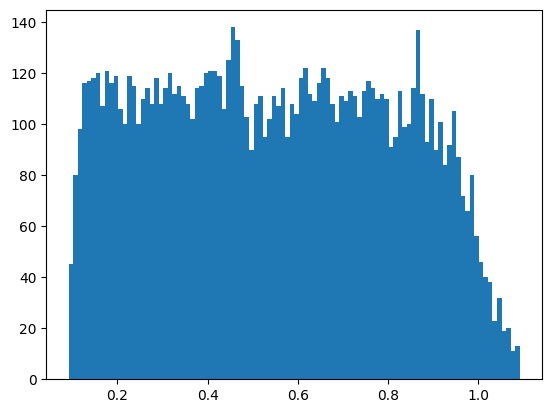

In [42]:
plt.hist(rir_pool["rt60_set"], bins=100)
plt.show()

In [45]:
# --------- CREATE METADATA FOR A DATASET BEING COMBINATIONS OF SPEECH, NOISE AND RIRS --------
from datetime import datetime
date_tag = datetime.now().strftime("%d-%m-%Y--%H-%M")
# create dataset with 20000 data points, which consists of random combinations of speech, noise and rirs
N_datapoints=30000

# # sample from noise pool: 
# df_noise=noise_pool.sample(N_datapoints,replace=True)
# # here plan ways to augment noise data set:
# random_bool_values = [random.choice([1, -1]) for _ in range(len(df_noise))]
# df_noise["aug_phase"]=random_bool_values

# sample from speech pool: 
df_speech=speech_pool.sample(N_datapoints)
# here plan ways to augment noise data set:
random_bool_values = [random.choice([1, -1]) for _ in range(len(df_speech))]
df_speech["aug_phase"]=random_bool_values

# sample from rir pool: 
df_rir=rir_pool.sample(N_datapoints,replace=True)

# concatenate samples from speech, noise and rir pools
# df_ds = pd.concat([df_speech.reset_index(drop=True), df_noise.reset_index(drop=True), df_rir.reset_index(drop=True)], axis=1,ignore_index=False)
df_ds = pd.concat([df_speech.reset_index(drop=True), df_rir.reset_index(drop=True)], axis=1,ignore_index=False)

df_ds = df_ds.reset_index(drop=True)

# randomize snr (only high snrs)
# df_ds["snr"]= 200 #np.random.uniform(low=10, high=30, size=len(df_ds))

# Create test-train-val split:
df_ds.loc[0:N_datapoints*0.8,"split"]="train" # 80% training data
df_ds.loc[N_datapoints*0.8:N_datapoints*0.9,"split"]="test" # 10% testing data
df_ds.loc[N_datapoints*0.9:N_datapoints,"split"]="val" # 10% validation data

df_ds.to_csv(date_tag+"_data_set.csv")


,database_speech,speech_file_path,aug_phase,room_x,room_y,room_z,volume,rt60_set,mic_pos_x,mic_pos_y,...,rt60_masp_stats,cd_masp_stats,mfp_masp_stats,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,database_rir,split
0,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,19.530267,19.109378,3.984920,1487.216866,0.776933,9.405102,11.929926,...,0.776995,2.468330,5.642083,1.384817,1.382337,0.661546,6.716298,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x195...,synth_rirs_mono,train
1,PTDB,/home/ubuntu/Data/PTDB/FEMALE/MIC/F07/mic_F07_...,-1,6.952810,4.274365,3.427451,101.859906,0.203739,3.884995,2.374596,...,0.203739,1.261508,2.987118,0.206066,0.211548,0.262468,16.575306,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x695...,synth_rirs_mono,train
2,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,9.348869,7.939615,2.510492,186.344858,0.267974,3.661253,5.084984,...,0.267989,1.487733,3.168348,0.380315,0.389583,0.296611,10.658538,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x935...,synth_rirs_mono,train
3,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,23.545237,11.830691,4.199111,1169.689413,0.697073,10.805491,5.926159,...,0.697089,2.311087,5.477306,1.192125,1.120866,0.682086,6.733581,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x235...,synth_rirs_mono,train
4,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,1,27.252399,18.713803,3.969250,2024.301534,0.825326,15.861772,11.134622,...,0.825282,2.794225,5.846803,1.593930,1.587210,0.582436,7.499043,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x272...,synth_rirs_mono,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,27.033556,26.870855,2.916027,2118.244992,0.971187,10.309420,13.148008,...,0.971133,2.634958,4.794571,2.261778,2.447717,1.671064,4.698061,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x270...,synth_rirs_mono,train
996,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,9.936703,5.924209,4.795116,282.274600,0.329011,4.928128,2.403284,...,0.328987,1.652615,4.184263,0.339560,0.328904,0.333747,11.669790,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x994...,synth_rirs_mono,train
997,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,10.230547,6.582065,2.874500,193.563445,0.304278,5.106496,3.697793,...,0.304261,1.423028,3.346938,0.414182,0.408793,0.368506,9.367142,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x102...,synth_rirs_mono,train
998,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,6.677118,4.432723,2.943855,87.131686,0.194296,2.807400,2.727977,...,0.194300,1.194751,2.797004,0.203584,0.204662,0.268937,15.998632,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x668...,synth_rirs_mono,train


In [12]:
# # Change paths in the metadata from GuestXR computer: 

# df = pd.read_csv("../dataset-metadata/nonoise2_guestxr2.csv",index_col=0)

# df["speech_file_path"]=df["speech_file_path"].str.replace("/home/ubuntu/Data/","/media/ssd2/")
# df["noise_file_path"]=df["noise_file_path"].str.replace("/home/ubuntu/Data/","/media/ssd2/")
# df["ir_file_path"]=df["ir_file_path"].str.replace("/home/ubuntu/Data/","/media/ssd2/")

# df.to_csv("../dataset-metadata/nonoise2_dacom.csv",index=False)

# df.head(10)

,database_speech,speech_file_path,database_noise,noise_file_path,aug_phase,room_x,room_y,room_z,volume,rt60_set,...,cd_masp_stats,mfp_masp_stats,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,database_rir,snr,split
0,librispeech,/media/ssd2/LibriMix/LibriSpeech/train-clean-1...,wham,/media/ssd2/wham/wham_noise/tr/01uo030s_1.9208...,1,20.356944,19.837310,4.267538,1723.347245,0.797306,...,2.623049,5.990526,1.358439,1.324450,0.465387,7.574104,/media/ssd2/synth_rirs_mono/monoRIR_x2036y1984...,synth_rirs_mono,200,train
1,librispeech,/media/ssd2/LibriMix/LibriSpeech/train-clean-1...,wham,/media/ssd2/wham/wham_noise/tr/20sa010i_1.2778...,1,22.813258,14.967837,4.589098,1567.016912,0.750975,...,2.577180,6.087320,1.221117,1.144523,0.493173,7.541716,/media/ssd2/synth_rirs_mono/monoRIR_x2281y1497...,synth_rirs_mono,200,train
2,VCTK,/media/ssd2/VCTK/wav48_silence_trimmed/p247/p2...,wham,/media/ssd2/wham/wham_noise/cv/027c0214_0.6624...,1,12.985778,11.598824,3.531631,531.933385,0.429641,...,1.985145,4.480505,0.601090,0.611684,0.378026,9.241051,/media/ssd2/synth_rirs_mono/monoRIR_x1299y1160...,synth_rirs_mono,200,train
3,librispeech,/media/ssd2/LibriMix/LibriSpeech/train-clean-1...,wham,/media/ssd2/wham/wham_noise/tr/01ec020r_2.4865...,1,26.994354,14.033851,2.990757,1133.002459,0.702691,...,2.265352,4.518093,1.467313,1.489414,0.887511,5.702895,/media/ssd2/synth_rirs_mono/monoRIR_x2699y1403...,synth_rirs_mono,200,train
4,VCTK,/media/ssd2/VCTK/wav48_silence_trimmed/p317/p3...,wham,/media/ssd2/wham/wham_noise/tr/01ic020a_0.4624...,-1,7.472313,7.210021,2.780418,149.796486,0.269339,...,1.330490,3.163649,0.331752,0.331296,0.350780,10.859154,/media/ssd2/synth_rirs_mono/monoRIR_x747y721z2...,synth_rirs_mono,200,train
5,librispeech,/media/ssd2/LibriMix/LibriSpeech/train-clean-1...,wham,/media/ssd2/wham/wham_noise/tr/019o0315_1.1245...,-1,27.257133,18.322527,3.036055,1516.265158,0.766824,...,2.508816,4.754659,1.652045,1.689787,1.056490,5.863899,/media/ssd2/synth_rirs_mono/monoRIR_x2726y1832...,synth_rirs_mono,200,train
6,VCTK,/media/ssd2/VCTK/wav48_silence_trimmed/p333/p3...,wham,/media/ssd2/wham/wham_noise/tr/205c0104_0.3999...,1,17.479244,16.493869,2.670974,770.042652,0.526206,...,2.158376,4.063103,1.044112,1.069466,0.652342,6.149875,/media/ssd2/synth_rirs_mono/monoRIR_x1748y1648...,synth_rirs_mono,200,train
7,VCTK,/media/ssd2/VCTK/wav48_silence_trimmed/p272/p2...,wham,/media/ssd2/wham/wham_noise/tr/20da010h_2.4019...,1,6.070682,5.523682,3.772643,126.506208,0.245936,...,1.279553,3.274228,0.239113,0.229818,0.343769,13.049105,/media/ssd2/synth_rirs_mono/monoRIR_x607y552z3...,synth_rirs_mono,200,train
8,librispeech,/media/ssd2/LibriMix/LibriSpeech/train-clean-1...,wham,/media/ssd2/wham/wham_noise/tr/028a010p_1.8049...,-1,21.091593,12.464904,4.685318,1231.792101,0.673197,...,2.413243,5.863896,1.030435,0.959109,0.396488,8.469015,/media/ssd2/synth_rirs_mono/monoRIR_x2109y1246...,synth_rirs_mono,200,train
9,VCTK,/media/ssd2/VCTK/wav48_silence_trimmed/p233/p2...,wham,/media/ssd2/wham/wham_noise/cv/025a010h_1.1923...,1,11.136938,10.264718,3.651445,417.424204,0.377974,...,1.874992,4.337675,0.479005,0.434067,0.342308,10.199988,/media/ssd2/synth_rirs_mono/monoRIR_x1114y1026...,synth_rirs_mono,200,train


In [3]:
# # Change paths in the metadata from GuestXR computer: 

# df = pd.read_csv("../dataset-metadata/check_data_set.csv",index_col=0)

# df["speech_file_path"]=df["speech_file_path"].str.replace("/home/ubuntu/Data/","/media/ssd2/")
# df["noise_file_path"]=df["noise_file_path"].str.replace("/home/ubuntu/Data/","/media/ssd2/")
# df["ir_file_path"]=df["ir_file_path"].str.replace("/home/ubuntu/Data/","/media/ssd2/")

# df.to_csv("../dataset-metadata/check_data_dacom.csv",index=False)

# df.head(10)

,database_speech,speech_file_path,database_noise,noise_file_path,aug_phase,room_x,room_y,room_z,volume,rt60_set,...,cd_masp_stats,mfp_masp_stats,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,database_rir,snr,split
0,librispeech,/media/ssd2/LibriMix/LibriSpeech/train-clean-1...,wham,/media/ssd2/wham/wham_noise/cv/01jc020n_0.8010...,1,10.408530,8.569011,2.833167,252.692484,0.340991,...,1.535780,3.535215,0.496810,0.472198,0.354950,8.776416,/media/ssd2/synth_rirs_mono/monoRIR_x1041y857z...,synth_rirs_mono,200,train
1,VCTK,/media/ssd2/VCTK/wav48_silence_trimmed/p264/p2...,wham,/media/ssd2/wham/wham_noise/tr/20do0103_1.5841...,-1,22.380681,15.394245,3.802599,1310.123425,0.804246,...,2.277045,5.367416,1.434295,1.409763,0.863535,6.147286,/media/ssd2/synth_rirs_mono/monoRIR_x2238y1539...,synth_rirs_mono,200,train
2,librispeech,/media/ssd2/LibriMix/LibriSpeech/train-clean-1...,wham,/media/ssd2/wham/wham_noise/tr/20nc010j_0.0354...,1,25.230784,21.997193,3.936739,2184.915268,0.871744,...,2.824394,5.897759,1.741936,1.750224,0.619352,7.495984,/media/ssd2/synth_rirs_mono/monoRIR_x2523y2200...,synth_rirs_mono,200,train
3,librispeech,/media/ssd2/LibriMix/LibriSpeech/train-clean-1...,wham,/media/ssd2/wham/wham_noise/tr/028o0311_0.8198...,-1,28.406355,20.753828,3.638830,2145.238292,0.928429,...,2.711981,5.583460,1.979188,2.028761,0.895035,6.637845,/media/ssd2/synth_rirs_mono/monoRIR_x2841y2075...,synth_rirs_mono,200,train
4,VCTK,/media/ssd2/VCTK/wav48_silence_trimmed/p257/p2...,wham,/media/ssd2/wham/wham_noise/cv/20to0102_1.06_2...,-1,28.791293,21.703649,3.341493,2088.019038,0.930732,...,2.672155,5.262114,2.018349,2.039160,1.250401,5.706346,/media/ssd2/synth_rirs_mono/monoRIR_x2879y2170...,synth_rirs_mono,200,train
5,VCTK,/media/ssd2/VCTK/wav48_silence_trimmed/p273/p2...,wham,/media/ssd2/wham/wham_noise/tr/40jc0218_2.3003...,1,6.605596,3.820116,3.062230,77.272739,0.173703,...,1.189973,2.703732,0.170070,0.179578,0.218555,19.002073,/media/ssd2/synth_rirs_mono/monoRIR_x661y382z3...,synth_rirs_mono,200,train
6,VCTK,/media/ssd2/VCTK/wav48_silence_trimmed/s5/s5_0...,wham,/media/ssd2/wham/wham_noise/tr/01io030x_2.3949...,-1,13.383597,9.101299,3.982889,485.148269,0.462189,...,1.827989,4.590665,0.620259,0.592379,0.498804,7.636294,/media/ssd2/synth_rirs_mono/monoRIR_x1338y910z...,synth_rirs_mono,200,train
7,librispeech,/media/ssd2/LibriMix/LibriSpeech/train-clean-1...,wham,/media/ssd2/wham/wham_noise/cv/015c020c_1.6883...,-1,13.924101,9.630467,4.054021,543.626309,0.459190,...,1.941209,4.735703,0.626253,0.588001,0.397751,8.848208,/media/ssd2/synth_rirs_mono/monoRIR_x1392y963z...,synth_rirs_mono,200,train
8,VCTK,/media/ssd2/VCTK/wav48_silence_trimmed/p306/p3...,wham,/media/ssd2/wham/wham_noise/tr/028o030j_0.2588...,1,20.047407,15.834776,4.892903,1553.233468,0.843746,...,2.420710,6.300968,1.333287,1.297209,0.812154,6.070088,/media/ssd2/synth_rirs_mono/monoRIR_x2005y1583...,synth_rirs_mono,200,train
9,VCTK,/media/ssd2/VCTK/wav48_silence_trimmed/p311/p3...,wham,/media/ssd2/wham/wham_noise/tr/022o030k_2.432_...,1,29.971840,27.573135,2.860347,2363.841136,0.994825,...,2.750090,4.770540,2.570848,2.757140,1.400890,5.953281,/media/ssd2/synth_rirs_mono/monoRIR_x2997y2757...,synth_rirs_mono,200,train


In [8]:

# df = pd.read_csv("../dataset-metadata/nonoise_48khz_guestxr.csv",index_col=0)
# df_pilot=df[0:300]
# df.to_csv("../dataset-metadata/nonoise_48khz_guestxr_pilot.csv",index=False)

,database_speech,speech_file_path,aug_phase,room_x,room_y,room_z,volume,rt60_set,mic_pos_x,mic_pos_y,...,rt60_masp_stats,cd_masp_stats,mfp_masp_stats,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,database_rir,split
0,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,19.530267,19.109378,3.984920,1487.216866,0.776933,9.405102,11.929926,...,0.776995,2.468330,5.642083,1.384817,1.382337,0.661546,6.716298,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x195...,synth_rirs_mono,train
1,PTDB,/home/ubuntu/Data/PTDB/FEMALE/MIC/F07/mic_F07_...,-1,6.952810,4.274365,3.427451,101.859906,0.203739,3.884995,2.374596,...,0.203739,1.261508,2.987118,0.206066,0.211548,0.262468,16.575306,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x695...,synth_rirs_mono,train
2,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,9.348869,7.939615,2.510492,186.344858,0.267974,3.661253,5.084984,...,0.267989,1.487733,3.168348,0.380315,0.389583,0.296611,10.658538,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x935...,synth_rirs_mono,train
3,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,23.545237,11.830691,4.199111,1169.689413,0.697073,10.805491,5.926159,...,0.697089,2.311087,5.477306,1.192125,1.120866,0.682086,6.733581,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x235...,synth_rirs_mono,train
4,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,1,27.252399,18.713803,3.969250,2024.301534,0.825326,15.861772,11.134622,...,0.825282,2.794225,5.846803,1.593930,1.587210,0.582436,7.499043,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x272...,synth_rirs_mono,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,PTDB,/home/ubuntu/Data/PTDB/FEMALE/MIC/F07/mic_F07_...,1,18.637080,11.650983,4.344229,943.307234,0.638092,11.321442,7.443467,...,0.638047,2.169328,5.410135,1.001069,0.924110,0.478620,7.528704,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x186...,synth_rirs_mono,train
96,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,25.236966,23.608062,3.970274,2365.473008,1.000258,15.052323,9.847676,...,1.000107,2.743853,5.990632,2.048334,2.084359,0.621052,6.956510,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x252...,synth_rirs_mono,train
97,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,27.426174,24.519402,3.952856,2658.190321,1.053743,13.779066,11.935911,...,1.053729,2.833699,6.056436,2.200199,2.277936,1.106309,6.063144,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x274...,synth_rirs_mono,train
98,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,8.293338,8.078850,3.914610,262.281354,0.365930,4.143975,4.532000,...,0.365947,1.510427,4.001505,0.407473,0.404585,0.394980,8.887916,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x828...,synth_rirs_mono,train
